In [1]:
import tables
import pandas as pd
import numpy as np
import h5py
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy import stats
from iminuit import Minuit
import math
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import emcee
from scipy.constants import c
from scipy.special import erf
from scipy.stats import hypsecant
from scipy.stats import norm
from scipy.stats import laplace

from scipy.integrate import quad

from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.halo import mass_so
from colossus.halo import concentration

from intergrid.intergrid import Intergrid
%load_ext cython

In [152]:
# new../
# old ./
for i in tqdm(range(50)):
    filename='../Downloads/UM_2d-20220418T173722Z-001/UM_2d/new_mock_2d_'+str(i)+'.npy'
    d = np.load(filename)
    df=pd.DataFrame.from_records(d.tolist(), columns=d.dtype.names)
    if i==0: df2=df
    else: df2=df2.append(df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [153]:
df2=df2.reset_index(drop=True)
df2

,id,upid,x,y,z,vz,sm,sfr,icl,mp,...,hostr,rich_red_sp,mar,Vol,n,ainf,vravg,bin3d,bin,tag
0,10423006138,-1,4.031440,17.234131,91.366623,267.779999,1.265675e+12,1.576690,9.841825e+11,1.092859e+14,...,0.976222,31.0,0.287099,3.897041,1,0.3023,NaN,0,0,1
1,30000005231481032,10423006138,4.156453,16.853609,91.404953,-93.482491,7.514302e+10,0.072503,2.526506e+10,6.548751e+12,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,6,6,0
2,32000004879831165,10423006138,3.719872,17.296618,91.075821,-586.436646,3.497926e+10,0.075920,5.277254e+08,1.145720e+12,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,6,4,0
3,27000005764327304,10423006138,3.860375,17.180166,91.220757,-889.141663,6.465858e+10,0.107494,0.000000e+00,9.529140e+11,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,3,2,0
4,16000007722938411,10423006138,3.409460,17.631683,91.215752,165.205124,5.195008e+10,0.110130,0.000000e+00,8.070051e+11,...,0.976222,31.0,0.287099,3.897041,1,0.0000,0.000000,11,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135423,10560991948,10560991969,992.138794,938.410095,920.661682,672.460022,4.058310e+10,4.102032,2.483552e+09,4.131869e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,188.889977,17,12,0
5135424,10560991881,10560991969,993.139038,937.326721,920.917542,464.279999,3.443873e+10,0.027448,5.711738e+08,7.876229e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,608.097782,17,16,0
5135425,10560991965,10560991969,991.583252,938.003296,921.428833,532.679993,1.037432e+10,0.003338,7.785041e+08,3.407543e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,506.714590,14,14,0
5135426,10560992045,10560991969,992.953857,937.915161,921.393127,338.950012,9.276681e+09,0.033343,3.186511e+09,7.508916e+11,...,0.823926,36.0,1.449028,2.342897,19,0.3023,139.517160,11,11,0


In [154]:
r_Mpc=df2.hostr*1e6 #Pc
G = 4.3009e-3 #M_solar^-1 pc (km/s)^2

In [155]:
df2['vcirc']=np.sqrt(G*df2.hostm/r_Mpc)

In [252]:
def nlnlikeorb(parameters):
    
    global v,r,rich, mymin, mymax
    
    lp=0

    withinlimits=[]
    for i in range(len(parameters)):
        withinlimits=np.append( withinlimits, (mymin[i]<parameters[i]<mymax[i]))
    if np.all(withinlimits.astype(bool)):
        lp=0
    else:
        lp=-np.inf
        
    sp_orb,q_orb, alpha_orb, r_porb,alpha_rorb=parameters
    
    lambda_p = np.median(rich)
    
    r_orb = r_porb*(rich/lambda_p)**alpha_rorb
    orb_sigmav_lam = sp_orb*(rich/lambda_p)**alpha_orb
    orb_sigmav = orb_sigmav_lam*(q_orb*np.exp(-(r/r_orb))+1)

    return np.sum(np.log(2*math.pi*(orb_sigmav**2))/2 + v**2/(2 * orb_sigmav**2) )
#    return -np.sum(np.log(orb_dist))-lp

In [253]:
sp_orb=3.5
q_orb=1.2
alpha_orb=0.4
r_porb=.5
alpha_rorb=.3

origin=[sp_orb,q_orb, alpha_orb, r_porb,alpha_rorb]

In [254]:
mymin=np.array([2,1e-8,1e-8,1e-8,1e-8])
mymax=np.array([10,5,2,1,2])

orbit=df2[(df2.tag == 0) & (df2.d2d>0.2)]

v=orbit.v/100
r=orbit.d2d*orbit.hostr
rich=orbit.hostm/1e14
#rich=orbit.rich_red_sp

labels=['s_porb','q_orb', 'alpha_orb', 'r_porb','alpha_rorb']
bnds=[(x,y) for x, y in zip(mymin, mymax)]


nlnlikeorb.errordef=0.5
q = Minuit(nlnlikeorb, origin,name=labels)
q.limits = bnds
q.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 9.519e+05                  │              Nfcn = 267              │
│ EDM = 3.25e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s_porb     │   4.202   │   0.012   │            │            │    2    │   10    │       │
│ 1 │ q_orb      │   1.341   │   0.024   │            │            │  1e-08  │    5    │       │
│ 2 │ alpha_orb  │   0.166   │   0.006   │            │            │  1e-08  │    2    │       │
│ 3 │ r_porb     │   0.232   │   0.004   │            │            │  1e-08  │    1    │       │
│ 4 │ alpha_rorb │   0.920   │   0.023   │            │            │  1e-08  │    2    │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬────────────────────────────────────────────────────────┐
│            │     s_porb      q_orb  alpha_orb     r_porb alpha_rorb │
├────────────┼────────────────────────────────────────────────────────┤
│     s_porb │   0.000138    1.6e-05   2.11e-05  -2.79e-05  -6.65e-05 │
│      q_orb │    1.6e-05   0.000564     -3e-05  -6.55e-05  -9.81e-06 │
│  alpha_orb │   2.11e-05     -3e-05    4.2e-05  -1.73e-07  -0.000133 │
│     r_porb │  -2.79e-05  -6.55e-05  -1.73e-07   1.41e-05   7.76e-06 │
│ alpha_rorb │  -6.65e-05  -9.81e-06  -0.000133   7.76e-06   0.000518 │
└────────────┴────────────────────────────────────────────────────────┘

In [255]:
orbradial_bins=np.linspace(0.3,3,30)
rbin_centers = (orbradial_bins[:-1] + orbradial_bins[1:])/2.
width=orbradial_bins[1]-orbradial_bins[0]
count=0

In [256]:
orbmean=[]
orbstd=[]
#parameters=origin
#parameters=mcmc_initial
parameters=np.array(q.values)
num_resample=50

for i in tqdm(range(len(orbradial_bins))):

    sp_orb,q_orb, alpha_orb, r_porb,alpha_rorb=parameters
    
    v=orbit.v/100
    r=orbit.d2d*orbit.hostr
    rich=orbit.hostm/1e14
    #rich=orbit.rich_red_sp
    lambda_p = np.median(rich)
    
    minr=orbradial_bins[i]-width
    maxr=orbradial_bins[i]+width
    
    dfcut=orbit[ (orbit.d2d>minr) & (orbit.d2d<=maxr) ].copy()
    dfcut=dfcut.reset_index()
    if (len(dfcut)!=0):
    
        v=dfcut.v/100
        r=dfcut.d2d*dfcut.hostr
        rich=dfcut.hostm/1e14
        #rich=dfcut.rich_red_sp

        orb_v = []

        for i in (range(num_resample)):
            r_orb = r_porb*(rich/lambda_p)**alpha_rorb
            orb_sigmav_lam = sp_orb*(rich/lambda_p)**alpha_orb
            orb_sigmav = orb_sigmav_lam*(q_orb*np.exp(-(r/r_orb))+1)
            orb_v = np.append(orb_v,orb_sigmav/dfcut.vcirc*100)
        
        orbmean=np.append(orbmean,np.mean(orb_v))
        orbstd=np.append(orbstd,np.std(orb_v))

  0%|          | 0/30 [00:00<?, ?it/s]

In [257]:
def llnorm(sigma):
    global dfcut
    data=dfcut.v/dfcut.vcirc
    ll = np.sum(math.log(2*math.pi*(sigma**2))/2 + ((data)**2)/(2 * (sigma**2)))

    
    return ll

In [290]:
def llnorm2(sigma):
    global dfcut
    data=dfcut.v/dfcut.vcirc
    inf_dist = 1/2.0/sigma/np.cosh(np.pi/2.0*data/sigma)
        
    return -np.sum(np.log(inf_dist))

In [305]:
N=25

intervals=np.linspace(0.3,3.0,N)
orbcenter=(intervals[:-1]+intervals[1:])/2
width=intervals[1]-intervals[0]
sigma_orb=[]
sigma_orb2=[]
orb_error=[]

orborigin=0.45
for plt_idx in tqdm(range(0,len(intervals)-1)):
    minr=intervals[plt_idx]-width
    maxr=intervals[plt_idx]+width
    
    dfcut=orbit[ (orbit.d2d>minr) & (orbit.d2d<=maxr)].copy()
    dfcut=dfcut.reset_index()
    v=dfcut.v/dfcut.vcirc

    #Try eliminating outliers first
    #std=np.std(v)
    #dfcut=dfcut[np.abs(dfcut.v/dfcut.vcirc)<2*std]

    llnorm2.errordef=0.5
    n = Minuit(llnorm2, [orborigin])
    n.migrad()
    orborigin=np.array(n.values)[0]
    print(np.array(n.values)[0],hypsecant.fit(dfcut.v/dfcut.vcirc,floc=0)[1]*np.pi/2)
    
    sigma_orb=np.append(sigma_orb,hypsecant.fit(dfcut.v/dfcut.vcirc,floc=0)[1]*np.pi/2)
    orb_error=np.append(orb_error,np.array(n.errors)[0])

  0%|          | 0/24 [00:00<?, ?it/s]

0.7103758299145152 0.7103933461073926
0.6573134942699219 0.6573095325689342
0.6063806411839735 0.6063729551810398
0.5641045920426206 0.5640808919539693
0.5294244468226433 0.5294373772084371
0.5017123316486815 0.501700095101467
0.4816973353142979 0.481685537592705
0.48039411181505265 0.48038121174199067
0.49138922650616984 0.49137341872104184
0.4979728858083138 0.49798373574875493
0.5106642448421975 0.5106688820457477
0.5250177778595613 0.5250437485742727
0.5362732233411402 0.5363132787635613
0.5455054941028212 0.5454965739502478
0.5465418110382303 0.5465123887827373
0.5372861103898471 0.5372524800611505
0.537318993281915 0.537274905890882
0.5450459092772854 0.5450799155968338
0.544648445604086 0.544667614848629
0.5395911271289742 0.5397096274577442
0.5564255023181451 0.5563818275210038
0.5617173425298394 0.56181447208909
0.5338212010118913 0.5338091152082275
0.5411067693821967 0.541274197273807


In [301]:
sigma_orb

array([0.71039335, 0.65730953, 0.60637296, 0.56408089, 0.52943738,
       0.5017001 , 0.48168554, 0.48038121, 0.49137342, 0.49798374,
       0.51066888, 0.52504375, 0.53631328, 0.54549657, 0.54651239,
       0.53725248, 0.53727491, 0.54507992, 0.54466761, 0.53970963,
       0.55638183, 0.56181447, 0.53380912, 0.5412742 ])

Text(0, 0.5, 'Velocity variance/v_circ')

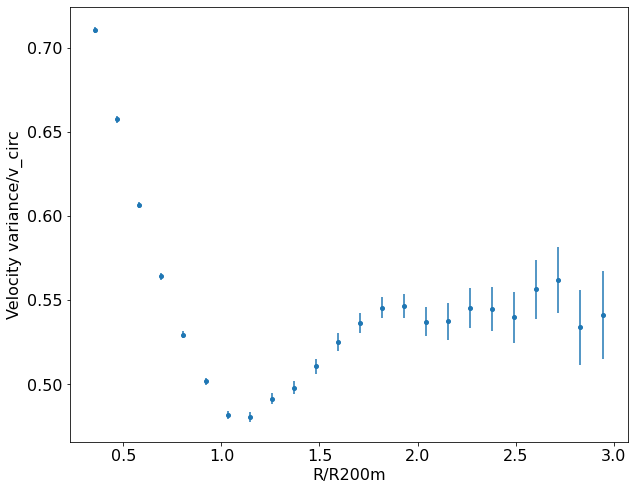

In [302]:
fig,(ax1) = plt.subplots(1, 1,figsize=(10,8))
ax1.errorbar(orbcenter, sigma_orb, yerr=orb_error, fmt='o',markersize=4)
#ax1.plot(orbradial_bins[:len(orbmean)],orbmean, label='orbiting')

#ax1.plot(center,sigma_bg)
ax1.set_xlabel('R/R200m')
ax1.set_ylabel('Velocity variance/v_circ')

In [231]:
SMALL_SIZE = 16
MEDIUM_SIZE = 36
BIGGER_SIZE = 70

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Text(0.5, 0, '$R/R_{200m}$')

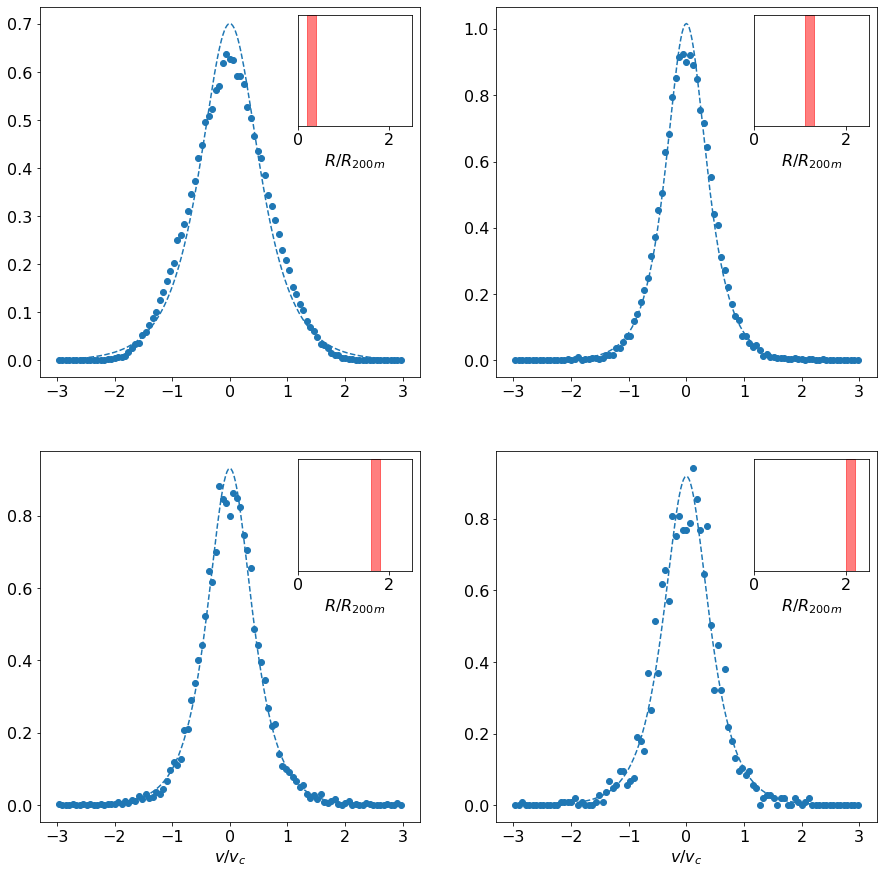

In [312]:
fig,[(ax1,ax2),(ax3,ax4)] = plt.subplots(2, 2,figsize=(15,15))
k=1

num_data_bin_edges = 100
num_sim_bin_edges = 2501
min_x = -3
max_x = 3
vv=np.linspace(-3,3,251)

data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
data_bin_width = data_bin_centers[1] - data_bin_centers[0]

minr=0.2
maxr=0.4

dfcut=orbit[ (orbit.d2d>minr) & (orbit.d2d <=maxr) ].copy()
dfcut=dfcut.reset_index()

v=dfcut.v/dfcut.vcirc

counts, bin_edges = np.histogram(v, data_x_vals)
hypsecantalized_counts = counts / len(v) / data_bin_width

#k=0.7
ax1.scatter(data_bin_centers, hypsecantalized_counts*k)
myscale=hypsecant.fit(v, floc=0)[1]
tdist=hypsecant.pdf(vv, loc=0, scale=myscale)
ax1.plot(vv,tdist*k,'--', label='0.1<R/$R_{edge}$<0.11')
#ax1.set_ylim([0,0.55])
ax1.set_yscale('linear')

inset_ax = inset_axes(ax1,
                  height="30%", # set height
                  width="30%", # and width
                  loc='upper right')
inset_ax.axvspan(minr, maxr, alpha=0.5, color='red')
inset_ax.set_xlim(0,2.5)
inset_ax.set_yticks([])
inset_ax.set_xlabel('$R/R_{200m}$') 

minr=1.1
maxr=1.3

dfcut=orbit[ (orbit.d2d>minr) & (orbit.d2d <=maxr) ].copy()
dfcut=dfcut.reset_index()

v=dfcut.v/dfcut.vcirc

counts, bin_edges = np.histogram(v, data_x_vals)
hypsecantalized_counts = counts / len(v) / data_bin_width

#k=0.4
ax2.scatter(data_bin_centers, hypsecantalized_counts*k)
myscale=hypsecant.fit(v, floc=0)[1]
tdist=hypsecant.pdf(vv, loc=0, scale=myscale)
ax2.plot(vv,tdist*k,'--', label='0.1<R/$R_{edge}$<0.11')
#ax2.set_ylim([0,0.55])
ax2.set_yscale('linear')

inset_ax = inset_axes(ax2,
                  height="30%", # set height
                  width="30%", # and width
                  loc='upper right')
inset_ax.axvspan(minr, maxr, alpha=0.5, color='red')
inset_ax.set_xlim(0,2.5)
inset_ax.set_yticks([])
inset_ax.set_xlabel('$R/R_{200m}$') 

minr=1.6
maxr=1.8

dfcut=orbit[ (orbit.d2d>minr) & (orbit.d2d <=maxr) ].copy()
dfcut=dfcut.reset_index()

v=dfcut.v/dfcut.vcirc

counts, bin_edges = np.histogram(v, data_x_vals)
hypsecantalized_counts = counts / len(v) / data_bin_width

ax3.scatter(data_bin_centers, hypsecantalized_counts*k)
myscale=hypsecant.fit(v, floc=0)[1]
tdist=hypsecant.pdf(vv, loc=0, scale=myscale)
ax3.plot(vv,tdist*k,'--', label='0.1<R/$R_{edge}$<0.11')
#ax3.set_ylim([0,0.55])
ax3.set_xlabel('$v/v_c$')
ax3.set_yscale('linear')


inset_ax = inset_axes(ax3,
                  height="30%", # set height
                  width="30%", # and width
                  loc='upper right')
inset_ax.axvspan(minr, maxr, alpha=0.5, color='red')
inset_ax.set_xlim(0,2.5)
inset_ax.set_yticks([])
inset_ax.set_xlabel('$R/R_{200m}$') 

minr=2.0
maxr=2.2

dfcut=orbit[ (orbit.d2d>minr) & (orbit.d2d <=maxr) ].copy()
dfcut=dfcut.reset_index()

v=dfcut.v/dfcut.vcirc

counts, bin_edges = np.histogram(v, data_x_vals)
hypsecantalized_counts = counts / len(v) / data_bin_width

#k=0.01
ax4.scatter(data_bin_centers, hypsecantalized_counts*k)
myscale=hypsecant.fit(v, floc=0)[1]
tdist=hypsecant.pdf(vv, loc=0, scale=myscale)
ax4.plot(vv,tdist*k,'--')
#ax4.set_ylim([0,0.55])
ax4.set_xlabel('$v/v_c$')
#ax4.set_xscale('linear')
ax4.set_yscale('linear')

inset_ax = inset_axes(ax4,
                  height="30%", # set height
                  width="30%", # and width
                  loc='upper right')
inset_ax.axvspan(minr, maxr, alpha=0.5, color='red')
inset_ax.set_xlim(0,2.5)
inset_ax.set_yticks([])
inset_ax.set_xlabel('$R/R_{200m}$')  
    
#Note for tomorrow: make plot method and sigma loop work without redge params

(-4.0, 4.0)

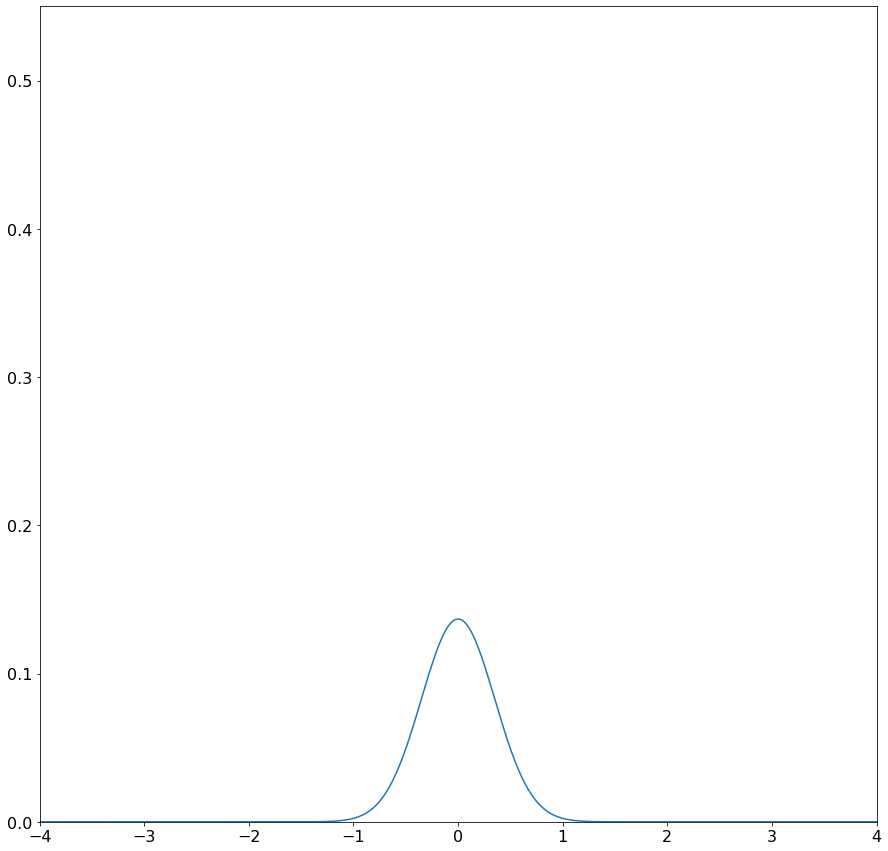

In [250]:
fig,ax1 = plt.subplots(1,1,figsize=(15,15))
vv=np.linspace(-4,4,500)
k=0.12
tdist=norm.pdf(vv, loc=0, scale=0.35)
ax1.plot(vv,tdist*k,'-')
ax1.set_ylim([0,0.55])
ax1.set_xlim([-4,4])

In [679]:
def lnlikeorb(parameters):
    return -nlnlikeorb(parameters)

In [688]:
orbit=df2[(df2.tag == 0) & (df2.d2d*df2.hostr>0.1)]
#orbit=orbit.sample(len(orbit)//100).reset_index(drop=True)
r=orbit.d2d*orbit.hostr
r_lambda=(orbit.rich_red_sp / 100.0) ** 0.2
r_edge=2.0*r_lambda
orbit = orbit[r/r_edge<0.8]
v=orbit.v/100
r=orbit.d2d*orbit.hostr
rich=orbit.hostm/1e14

#Parameters that Paxton's mcmc is initialized with
ndim, nwalkers = len(np.array(q.values)),40
pos = [np.array(q.values) + np.random.normal(0,np.array(q.errors)) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikeorb)

In [689]:
sampler.run_mcmc(pos, 20000,progress=True); #run a 1000 length chain starting at pos

  0%|          | 51/20000 [00:59<5:23:34,  1.03it/s] /home/mr.bwolfe/.conda/envs/redmapper/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 20000/20000 [14:21:34<00:00,  2.58s/it]       


In [690]:
import corner

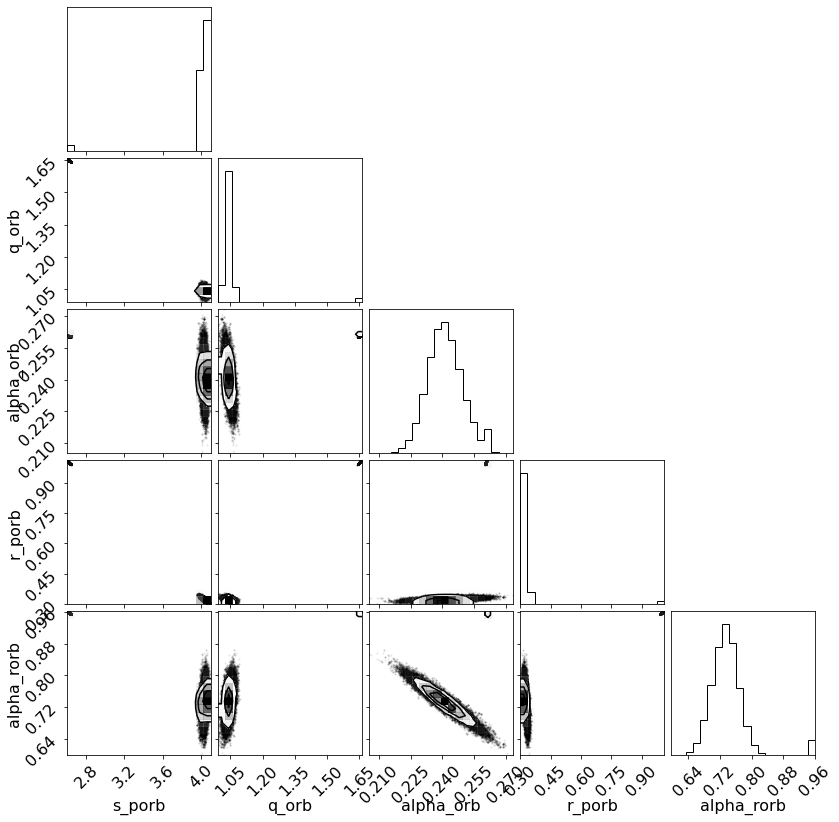

In [709]:
samples = sampler.get_chain(discard=18000, thin=1, flat=False)
samples = samples.reshape((-1, len(np.array(origin))))
fig = corner.corner(samples, labels=labels)

In [327]:
flat_samples = sampler.get_chain(discard=10000, flat=True)

In [328]:
from IPython.display import display, Math

mcmc_50=[]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    mcmc_50=np.append(mcmc_50,mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [693]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
#p, lnsigma_p, alpha, beta = flat_chain[max_prob_idx]
mcmc_initial=flat_chain[max_prob_idx]

In [124]:
mcmc_initial

NameError: name 'mcmc_initial' is not defined

In [710]:
import pickle

filehandler = open("orbmodel_20000chain.obj","wb")
pickle.dump(sampler,filehandler)
filehandler.close()

In [711]:
flat_samples = sampler.get_chain(discard=0, thin=1, flat=True)
np.save('orbmodel_flatsamples_20000.npy', flat_samples) 